<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

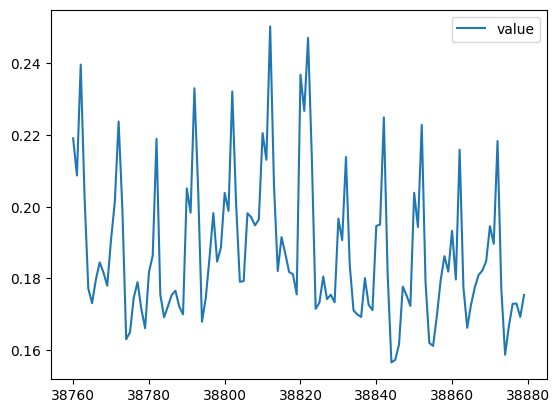

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_584300/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 113.50471870941028 %
smape 95.90566895248597 %
smape 78.93901999059476 %
smape 48.70341603388215 %
smape 14.515985193831183 %
smape 11.084435051470471 %
smape 10.23299287547145 %
smape 9.802916795451042 %
smape 9.599505740473841 %
smape 9.45908444928147 %
smape 9.371674270396344 %
smape 9.540756966548356 %
smape 9.45649148820088 %
smape 9.524476092025552 %
smape 9.581255789911538 %
smape 9.331087858704795 %
smape 9.174262093957404 %
smape 9.1654384340982 %
smape 9.241493843626557 %
smape 9.214801057650332 %
smape 9.097721279538863 %
smape 9.216184891019648 %
smape 9.340388174468314 %
smape 9.626871858511056 %
smape 9.778257591421143 %
smape 9.718142775328536 %
smape 9.686264180039105 %
smape 9.794255017101417 %
smape 9.608088377100682 %
smape 9.376102602708409 %
smape 9.21371473729262 %
smape 9.015411185590844 %
smape 9.055726361292148 %
smape 9.038517882078015 %
smape 9.214010161091709 %
smape 9.43229371954126 %
smape 9.633020384356989 %
smape 9.56353172049885 %
smape 9.74833056

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.1603138279315317 %
SMAPE 4.899882770381737 %
SMAPE 1.02352910335685 %
SMAPE 0.6533976833306951 %
SMAPE 0.16134343377234472 %
SMAPE 0.2429966266136034 %
SMAPE 0.9295468393920601 %
SMAPE 0.39796970913383234 %
SMAPE 0.26145590677879227 %
SMAPE 0.41133348321091034 %
SMAPE 0.7359953431878239 %
SMAPE 0.7125568642586586 %
SMAPE 0.5961982066619385 %
SMAPE 0.2894674960652992 %
SMAPE 0.9457840431277873 %
SMAPE 0.6988079406582983 %
SMAPE 1.0966035995752463 %
SMAPE 3.493485950195464 %
SMAPE 0.7863208678281808 %
SMAPE 0.36073137729545124 %
SMAPE 1.6696854765696114 %
SMAPE 0.4210414863846382 %
SMAPE 2.381895019709191 %
SMAPE 0.3351795824446526 %
SMAPE 1.0873335194428364 %
SMAPE 2.6549670463668917 %
SMAPE 0.10978038160556025 %
SMAPE 0.49321915225300467 %
SMAPE 0.98567336735141 %
SMAPE 0.20984895721630892 %
SMAPE 0.307192103642592 %
SMAPE 0.8259088990562303 %
SMAPE 0.4098766437964514 %
SMAPE 0.27472343821500544 %
SMAPE 0.6273628623930563 %
SMAPE 0.7369069904452772 %
SMAPE 0.2576281380170258 %


SMAPE 2.133585507181124 %
SMAPE 0.3180525259267597 %
SMAPE 0.4021295006668879 %
SMAPE 2.1479801631503506 %
SMAPE 0.41051960127515486 %
SMAPE 1.0391732529078581 %
SMAPE 0.3664306654845859 %
SMAPE 0.18630739604850532 %
SMAPE 0.6986612192558823 %
SMAPE 1.15074063670545 %
SMAPE 1.3515570840809232 %
SMAPE 1.6070408343728102 %
SMAPE 6.177863819029881 %
SMAPE 3.3471027796404087 %
SMAPE 0.4349990506143513 %
SMAPE 1.2567764135019388 %
SMAPE 0.3953389172320385 %
SMAPE 1.0383534510765458 %
SMAPE 0.6334788818385277 %
SMAPE 0.3677053093961149 %
SMAPE 0.0808305492018917 %
SMAPE 0.12609710911056027 %
SMAPE 0.4122404205118073 %
SMAPE 0.3067493763028324 %
SMAPE 0.4577801186578654 %
SMAPE 1.5915515046890503 %
SMAPE 0.7348680135210088 %
SMAPE 0.5780653923138743 %
SMAPE 0.25608568335246673 %
SMAPE 1.9127125325467205 %
SMAPE 2.920608677330165 %
SMAPE 0.7717296525302118 %
SMAPE 0.26139980440257204 %
SMAPE 0.29482363020360935 %
SMAPE 0.6458159525006977 %
SMAPE 1.022937991496292 %
SMAPE 0.32052449151160545 %


SMAPE 0.26084228723630076 %
SMAPE 0.3323908538272917 %
SMAPE 0.8260918119485723 %
SMAPE 0.5240300824152655 %
SMAPE 1.0060538892612385 %
SMAPE 0.5766363134516723 %
SMAPE 0.46265287994174287 %
SMAPE 0.32742466259514913 %
SMAPE 1.095706622451189 %
SMAPE 0.25417039165768074 %
SMAPE 0.30081365282967454 %
SMAPE 0.3534666051091335 %
SMAPE 0.5504794787102583 %
SMAPE 0.5283181039994815 %
SMAPE 0.5468630569430388 %
SMAPE 1.25176692482637 %
SMAPE 0.30220213334996515 %
SMAPE 0.10205609612285114 %
SMAPE 0.30582329411117826 %
SMAPE 0.40472687083092757 %
SMAPE 0.5667375164375699 %
SMAPE 1.2688306598756753 %
SMAPE 0.2032103538949741 %
SMAPE 0.3427604141311349 %
SMAPE 1.6258000243251445 %
SMAPE 0.6557195044460968 %
SMAPE 0.16420308362830838 %
SMAPE 0.24121156323681703 %
SMAPE 1.1618744168663397 %
SMAPE 0.1503061287608034 %
SMAPE 0.18254569913040086 %
SMAPE 0.1702433388454665 %
SMAPE 1.0166266079177149 %
SMAPE 0.0663923700203668 %
SMAPE 0.19993037488620757 %
SMAPE 0.23494607125940092 %
SMAPE 0.283943688

SMAPE 0.22430888318922373 %
SMAPE 0.49633290047313494 %
SMAPE 0.4675143933673099 %
SMAPE 0.10129371411744614 %
SMAPE 0.27566623788152356 %
SMAPE 0.2559115965887031 %
SMAPE 0.1698046159290243 %
SMAPE 0.11920554818880191 %
SMAPE 0.08556060827049805 %
SMAPE 0.19021989548855345 %
SMAPE 0.6544724956990038 %
SMAPE 0.275880222156502 %
SMAPE 1.4770087865617825 %
SMAPE 0.27238840790232643 %
SMAPE 0.4703989831759827 %
SMAPE 0.1265929950241116 %
SMAPE 0.9442965609960083 %
SMAPE 0.27718318383631413 %
SMAPE 0.15782194924977944 %
SMAPE 0.08753804581868962 %
SMAPE 0.2362606091539874 %
SMAPE 0.3855874112196034 %
SMAPE 0.7546104957618809 %
SMAPE 0.5190809149735287 %
SMAPE 0.0739124336905661 %
SMAPE 0.8300746390159476 %
SMAPE 1.0745061461784644 %
SMAPE 0.06225356084678424 %
SMAPE 0.13784093500999006 %
SMAPE 0.16350545135355787 %
SMAPE 0.1349607639531314 %
SMAPE 0.4556239540615934 %
SMAPE 0.19753973544106884 %
SMAPE 1.1009818824086324 %
SMAPE 0.13206364783400204 %
SMAPE 0.294955690687857 %
SMAPE 0.117693

SMAPE 0.3969615741516464 %
SMAPE 0.7365934713598108 %
SMAPE 0.24936804953631508 %
SMAPE 0.33799728188023437 %
SMAPE 0.17466304242771002 %
SMAPE 0.3831864855492313 %
SMAPE 0.5179354964493541 %
SMAPE 0.2558523000391233 %
SMAPE 0.9408167119756854 %
SMAPE 0.21456244234195765 %
SMAPE 0.1090773819523747 %
SMAPE 0.06235689694767643 %
SMAPE 0.18266925626903685 %
SMAPE 0.09374431920241477 %
SMAPE 0.5038969805855231 %
SMAPE 1.3569716609199531 %
SMAPE 0.3169009131961502 %
SMAPE 0.193169551952451 %
SMAPE 0.4161958520542157 %
SMAPE 0.2261772142519476 %
SMAPE 0.44933999506611144 %
SMAPE 0.14370099340885645 %
SMAPE 0.5172107544785831 %
SMAPE 0.6911195560603574 %
SMAPE 0.4914185384909615 %
SMAPE 0.6750463728533305 %
SMAPE 0.8538245002418988 %
SMAPE 0.3574249029488783 %
SMAPE 0.5487419084493013 %
SMAPE 0.2473922402023163 %
SMAPE 0.08417636472040613 %
SMAPE 0.4234449758687333 %
SMAPE 0.8429273993779135 %
SMAPE 0.14205155092895438 %
SMAPE 0.6013418763241134 %
SMAPE 0.5559508171136258 %
SMAPE 0.1185010840

SMAPE 0.27270696513753023 %
SMAPE 0.055062721470562785 %
SMAPE 0.9348846449356643 %
SMAPE 0.6055408279480616 %
SMAPE 0.18038031949799915 %
SMAPE 0.524976493739814 %
SMAPE 0.19169551994491485 %
SMAPE 0.2917088700905879 %
SMAPE 0.28237262990660383 %
SMAPE 0.17208209834825539 %
SMAPE 0.24484013466371835 %
SMAPE 0.42315519586372835 %
SMAPE 0.4294726186026309 %
SMAPE 0.33412172434964305 %
SMAPE 0.6400596570019843 %
SMAPE 0.2715871603851383 %
SMAPE 0.1235175931564072 %
SMAPE 0.42403879266203154 %
SMAPE 0.1842740536144447 %
SMAPE 0.4794315700073639 %
SMAPE 1.4669508643455629 %
SMAPE 0.2825258899288201 %
SMAPE 0.08330888342425169 %
SMAPE 0.7149514690936485 %
SMAPE 0.6956419023126728 %
SMAPE 0.28403905547747854 %
SMAPE 0.21518234343238873 %
SMAPE 0.2314244144508848 %
SMAPE 0.9961600164788251 %
SMAPE 0.38072170668601757 %
SMAPE 0.5135980390041368 %
SMAPE 0.9604443578527935 %
SMAPE 0.18111919913008023 %
SMAPE 0.2962193770608792 %
SMAPE 0.5845362987638509 %
SMAPE 0.35724439614568837 %
SMAPE 0.2084

SMAPE 2.3503164276771713 %
SMAPE 0.880101772188027 %
SMAPE 0.05529298416513484 %
SMAPE 0.1008209414940211 %
SMAPE 0.5059112385133631 %
SMAPE 0.2769724563577256 %
SMAPE 0.3890364541057352 %
SMAPE 0.4600851868981408 %
SMAPE 0.145211937095155 %
SMAPE 0.32666922972975954 %
SMAPE 0.6167226584172454 %
SMAPE 0.22486270503577543 %
SMAPE 1.5078251768027258 %
SMAPE 0.6310322935532895 %
SMAPE 0.28401378970738733 %
SMAPE 0.7831403043674072 %
SMAPE 0.15837808948163 %
SMAPE 0.25711597843246636 %
SMAPE 0.4649228085918366 %
SMAPE 0.06142075749630749 %
SMAPE 1.0799613865656283 %
SMAPE 0.7138984700141009 %
SMAPE 0.21693399390642298 %
SMAPE 0.34124219545628875 %
SMAPE 0.5645555260871333 %
SMAPE 1.4742259669146733 %
SMAPE 0.5511714357253368 %
SMAPE 0.5810226091471122 %
SMAPE 0.21203922250242613 %
SMAPE 6.239038590436394 %
SMAPE 3.5951625094021438 %
SMAPE 0.8780707425976287 %
SMAPE 1.512921732498171 %
SMAPE 0.8237649549409981 %
SMAPE 0.23687617571704322 %
SMAPE 0.5636193551654287 %
SMAPE 0.1148713058228168

SMAPE 0.04354523111351227 %
SMAPE 0.1522852741488805 %
SMAPE 0.11964985658187287 %
SMAPE 0.2455397320445627 %
SMAPE 0.9060347478907715 %
SMAPE 0.5333889084977272 %
SMAPE 0.36689461145942914 %
SMAPE 0.16370073196867452 %
SMAPE 0.26555568182061506 %
SMAPE 0.2567327953474887 %
SMAPE 0.3004091787854577 %
SMAPE 0.2421766395549554 %
SMAPE 0.8114314371923683 %
SMAPE 0.17463013250130643 %
SMAPE 1.6067063847203826 %
SMAPE 1.3701202981828828 %
SMAPE 2.389553828024873 %
SMAPE 0.5109981324708315 %
SMAPE 0.15483495254329682 %
SMAPE 0.16621709681658103 %
SMAPE 0.6609790444736063 %
SMAPE 0.22947335878779995 %
SMAPE 0.4643345984832194 %
SMAPE 0.27098230365663767 %
SMAPE 0.23192050042416668 %
SMAPE 0.1440594598534517 %
SMAPE 0.5369241704602246 %
SMAPE 0.40069151218904153 %
SMAPE 0.6698919353439123 %
SMAPE 0.11882904251797301 %
SMAPE 0.2650331670192827 %
SMAPE 0.4883560444377508 %
SMAPE 0.15624648119683116 %
SMAPE 0.18161360371872348 %
SMAPE 0.08030862620216794 %
SMAPE 0.7934794513566885 %
SMAPE 0.11733

SMAPE 0.4869618244247249 %
SMAPE 1.8056640767754288 %
SMAPE 1.447877146780229 %
SMAPE 0.27090294676600024 %
SMAPE 1.0304037977293774 %
SMAPE 0.14234182322616107 %
SMAPE 0.1846870885037788 %
SMAPE 0.14379709050263045 %
SMAPE 0.7454791618010859 %
SMAPE 0.10727099492623893 %
SMAPE 0.20686447334810507 %
SMAPE 0.10518073254570481 %
SMAPE 0.062400442609771296 %
SMAPE 0.607285094440158 %
SMAPE 4.0286184148435495 %
SMAPE 1.4620345149578498 %
SMAPE 0.176702692582694 %
SMAPE 0.14656561323636197 %
SMAPE 0.879262884093805 %
SMAPE 1.1410430071482551 %
SMAPE 1.2009712451399537 %
SMAPE 1.6367069216248638 %
SMAPE 0.5398614421792445 %
SMAPE 0.7496915498813905 %
SMAPE 1.2721780472395494 %
SMAPE 1.1283465373412582 %
SMAPE 0.49520942233539245 %
SMAPE 0.21312404531863646 %
SMAPE 0.5331237685148835 %
SMAPE 0.235877988238542 %
SMAPE 1.296426583587163 %
SMAPE 1.035151252961441 %
SMAPE 0.27824094930610954 %
SMAPE 0.7091742514166981 %
SMAPE 0.5698786590146483 %
SMAPE 1.7210216396633768 %
SMAPE 0.464381457783019

SMAPE 0.1782627375687298 %
SMAPE 0.8376826359872213 %
SMAPE 0.1973518452468852 %
SMAPE 0.09529601584654301 %
SMAPE 0.5238355231194873 %
SMAPE 0.1762294064537855 %
SMAPE 0.644403791266086 %
SMAPE 0.06325762478354591 %
SMAPE 0.11996022041071797 %
SMAPE 0.28757554000640084 %
SMAPE 0.32857874572982837 %
SMAPE 0.19923901022161772 %
SMAPE 0.7229671379709544 %
SMAPE 0.27011466412125174 %
SMAPE 0.41304659089655615 %
SMAPE 0.8871789711120073 %
SMAPE 0.31490649733336795 %
SMAPE 0.7531467309399886 %
SMAPE 0.3555107739412051 %
SMAPE 0.1761598322827922 %
SMAPE 0.1922664668163634 %
SMAPE 0.3840658289263956 %
SMAPE 0.12723441016896686 %
SMAPE 0.4159865980736868 %
SMAPE 1.2600720415794058 %
SMAPE 0.7527674390657921 %
SMAPE 0.9150538918402163 %
SMAPE 1.955482007389037 %
SMAPE 0.13052700877960888 %
SMAPE 0.1635997063335708 %
SMAPE 0.8955792688047949 %
SMAPE 0.1404322625844543 %
SMAPE 0.1450805977069649 %
SMAPE 0.5332360560780671 %
SMAPE 0.7046098757818982 %
SMAPE 0.7505077887526568 %
SMAPE 0.17017341182

SMAPE 0.2231782876640409 %
SMAPE 0.20616127811126714 %
SMAPE 0.14432555539360692 %
SMAPE 0.21802085274771343 %
SMAPE 0.13118316736745328 %
SMAPE 0.42611285322936965 %
SMAPE 2.5604930781519215 %
SMAPE 0.6078718044263951 %
SMAPE 0.1227950850770867 %
SMAPE 1.65447047056864 %
SMAPE 0.8398657240322791 %
SMAPE 0.558246592838259 %
SMAPE 0.21325561115008895 %
SMAPE 0.12727813958326806 %
SMAPE 2.2358354624711865 %
SMAPE 0.47119961842872726 %
SMAPE 2.3015432527790836 %
SMAPE 0.8533751087124983 %
SMAPE 0.5129663283587433 %
SMAPE 0.6045470387281284 %
SMAPE 0.3208297036064778 %
SMAPE 0.8823708747186174 %
SMAPE 0.5154625529849 %
SMAPE 0.1386654828825158 %
SMAPE 0.1311099704416847 %
SMAPE 1.2448576812676038 %
SMAPE 0.8708316520514927 %
SMAPE 0.06364715779000107 %
SMAPE 0.6206087959180877 %
SMAPE 0.42032667597959517 %
SMAPE 0.7918305276580212 %
SMAPE 0.7923121990679648 %
SMAPE 0.2685821336863228 %
SMAPE 0.3872957107723778 %
SMAPE 0.14509440015490327 %
SMAPE 0.1650721613168571 %
SMAPE 0.381516747095702

SMAPE 0.21092260126533802 %
SMAPE 0.3073363161893212 %
SMAPE 0.46918669370256794 %
SMAPE 0.327709979541396 %
SMAPE 0.42038052103589507 %
SMAPE 0.6381170745089548 %
SMAPE 0.22673941194511826 %
SMAPE 0.5912862424156629 %
SMAPE 0.4369428040645289 %
SMAPE 0.29094751834782073 %
SMAPE 0.10928510993835516 %
SMAPE 0.9070801500674861 %
SMAPE 0.9905825137980172 %
SMAPE 0.6106446466559987 %
SMAPE 0.7354992566833971 %
SMAPE 0.8325076872865792 %
SMAPE 0.16550378812280542 %
SMAPE 0.2705950718848271 %
SMAPE 0.40691572460218595 %
SMAPE 1.2461460786666407 %
SMAPE 0.188666420136542 %
SMAPE 0.24050471512782676 %
SMAPE 0.06292553430012049 %
SMAPE 1.4599580778703967 %
SMAPE 0.1494935555392658 %
SMAPE 0.8951231837208979 %
SMAPE 0.055730734537064563 %
SMAPE 0.7361510693862527 %
SMAPE 0.8465147567458189 %
SMAPE 0.754928641224069 %
SMAPE 2.1452106715369155 %
SMAPE 0.9780983117507277 %
SMAPE 0.09628495157812722 %
SMAPE 1.1222258034558763 %
SMAPE 0.0989460198593406 %
SMAPE 0.4553444450439201 %
SMAPE 0.0708189055

SMAPE 0.7971358575487102 %
SMAPE 0.8829590730892961 %
SMAPE 0.17482450560601137 %
SMAPE 0.35427358212473337 %
SMAPE 0.36990546336028274 %
SMAPE 0.17635779983811517 %
SMAPE 0.7242049863416469 %
SMAPE 3.402359533065465 %
SMAPE 0.09077026469356042 %
SMAPE 0.3794638469871643 %
SMAPE 0.2345398511934036 %
SMAPE 0.3629656878736114 %
SMAPE 0.16402363968745703 %
SMAPE 0.1691118890303187 %
SMAPE 0.44417395529308124 %
SMAPE 0.13787864717778575 %
SMAPE 0.20605801091369358 %
SMAPE 0.2942182995911935 %
SMAPE 0.3517326140408841 %
SMAPE 0.48360133088681323 %
SMAPE 0.11533205262639967 %
SMAPE 0.39797348022693774 %
SMAPE 0.17983466806981596 %
SMAPE 0.496766815389492 %
SMAPE 0.08315561461313337 %
SMAPE 0.2736085878641461 %
SMAPE 1.2397134697803267 %
SMAPE 0.30413913336087717 %
SMAPE 0.6968993149057496 %
SMAPE 0.9091876655056695 %
SMAPE 0.7371104015310266 %
SMAPE 0.4371331739994275 %
SMAPE 0.6694676471049661 %
SMAPE 0.11263432756095428 %
SMAPE 0.12812350968488317 %
SMAPE 0.37807139725919114 %
SMAPE 0.1830

SMAPE 0.0644424092192537 %
SMAPE 0.3685212906052584 %
SMAPE 0.2417194336940156 %
SMAPE 0.5111327078193426 %
SMAPE 0.17243577581393765 %
SMAPE 0.42740549887230367 %
SMAPE 0.3759947377802746 %
SMAPE 1.8097565183270488 %
SMAPE 1.0671685263077961 %
SMAPE 0.19793761761411588 %
SMAPE 1.2263539841692364 %
SMAPE 0.3022112386097433 %
SMAPE 0.23959835974710586 %
SMAPE 0.0864452730584162 %
SMAPE 0.1355130939218725 %
SMAPE 0.8409595359494234 %
SMAPE 0.18896014839992858 %
SMAPE 0.3799670694907036 %
SMAPE 1.2200310978623747 %
SMAPE 0.46520949980185833 %
SMAPE 0.0938316276851765 %
SMAPE 0.0844281756815235 %
SMAPE 0.13019749366867472 %
SMAPE 0.4197776600631187 %
SMAPE 0.10014349964740177 %
SMAPE 0.23479631844929827 %
SMAPE 0.31295867294647906 %
SMAPE 0.4114278598331111 %
SMAPE 0.24112039208694114 %
SMAPE 0.4559831857473 %
SMAPE 0.4361582737437857 %
SMAPE 0.37076817737397505 %
SMAPE 1.0388455023858114 %
SMAPE 0.4155081373537542 %
SMAPE 0.0765019969026639 %
SMAPE 0.12104320196704066 %
SMAPE 0.2062974460

SMAPE 0.5542679807767854 %
SMAPE 0.502802115301165 %
SMAPE 0.9166571211781047 %
SMAPE 0.34016426115704235 %
SMAPE 0.6665650914728758 %
SMAPE 1.4449891652948281 %
SMAPE 0.049204551994648675 %
SMAPE 0.42238674412055843 %
SMAPE 0.0935489859257359 %
SMAPE 0.49289950932234206 %
SMAPE 0.4225756267878751 %
SMAPE 1.0402597179827353 %
SMAPE 0.13879474901239064 %
SMAPE 0.2013236166758361 %
SMAPE 0.5548452577113494 %
SMAPE 0.07450387463177321 %
SMAPE 0.35922267880107484 %
SMAPE 0.34155607154025347 %
SMAPE 0.3843072470044717 %
SMAPE 0.07691302599005212 %
SMAPE 0.2141428654103947 %
SMAPE 0.34514899125406373 %
SMAPE 0.20331463353613796 %
SMAPE 0.17610378621793643 %
SMAPE 0.16902577395740082 %
SMAPE 0.5037038024183857 %
SMAPE 0.39896114288239914 %
SMAPE 0.13797269516044253 %
SMAPE 0.3981963678699003 %
SMAPE 0.4636503894571434 %
SMAPE 0.1660125460330164 %
SMAPE 0.43634100927010877 %
SMAPE 0.3717594856927917 %
SMAPE 0.09496980910989805 %
SMAPE 0.2453326529594051 %
SMAPE 0.2651862049825695 %
SMAPE 0.224

SMAPE 0.48085186207754305 %
SMAPE 0.3716172770218691 %
SMAPE 0.6530586378999033 %
SMAPE 0.18295828151133264 %
SMAPE 0.20938035882045372 %
SMAPE 0.8884513649099972 %
SMAPE 1.008253825675638 %
SMAPE 2.265013334879768 %
SMAPE 0.09791036497153983 %
SMAPE 3.0059054390367237 %
SMAPE 0.5645871633369097 %
SMAPE 0.4221913975361531 %
SMAPE 1.9156737480607262 %
SMAPE 0.22667238313783855 %
SMAPE 1.240690394055946 %
SMAPE 2.8626262763500563 %
SMAPE 0.2258452759069769 %
SMAPE 0.13727291702889488 %
SMAPE 0.18992585781211346 %
SMAPE 0.7451426448678831 %
SMAPE 1.2201991049805656 %
SMAPE 0.10658806140463638 %
SMAPE 0.574703488531668 %
SMAPE 0.1865837710147389 %
SMAPE 0.760229584742774 %
SMAPE 0.4484937509505471 %
SMAPE 0.4765312148319936 %
SMAPE 0.48455735611138095 %
SMAPE 0.09425046663591274 %
SMAPE 0.28004617076862814 %
SMAPE 0.4649796239682473 %
SMAPE 0.2851538121522026 %
SMAPE 1.061316799656197 %
SMAPE 0.47767909970207256 %
SMAPE 0.3196491127164336 %
SMAPE 0.22590130885691903 %
SMAPE 0.7494416188274

SMAPE 0.2617491740645619 %
SMAPE 0.135312374503485 %
SMAPE 0.4648793622150152 %
SMAPE 0.6800050165220455 %
SMAPE 0.78275771812514 %
SMAPE 0.7351798717372731 %
SMAPE 0.4967855222048456 %
SMAPE 2.180213435117878 %
SMAPE 0.1526449633095126 %
SMAPE 0.448027825421832 %
SMAPE 0.17810284385768682 %
SMAPE 0.12113793476601133 %
SMAPE 0.45751382592607115 %
SMAPE 0.9598768476298574 %
SMAPE 0.2599996489034311 %
SMAPE 0.2013323156900242 %
SMAPE 0.2674937407227844 %
SMAPE 0.4206993143911859 %
SMAPE 0.10146576143506536 %
SMAPE 0.11992433210252784 %
SMAPE 0.869528961728065 %
SMAPE 0.1978646174975438 %
SMAPE 0.3545977669441527 %
SMAPE 0.28950486555731914 %
SMAPE 0.09267232345428056 %
SMAPE 0.31544868209448396 %
SMAPE 0.2476449410751229 %
SMAPE 0.39013550570234656 %
SMAPE 0.11185882713107276 %
SMAPE 0.6288406005987781 %
SMAPE 0.22757870283992074 %
SMAPE 0.7051413829367448 %
SMAPE 4.185038118092052 %
SMAPE 1.7664523803032355 %
SMAPE 0.2880702494439902 %
SMAPE 0.3511809787087259 %
SMAPE 1.3441239846019926

SMAPE 0.47277565598051297 %
SMAPE 0.2976034077028089 %
SMAPE 0.3888584256401373 %
SMAPE 0.9152492423345393 %
SMAPE 0.28287096513395227 %
SMAPE 0.5811419445217325 %
SMAPE 0.23634450763552195 %
SMAPE 0.37233747329446487 %
SMAPE 0.5440118988544782 %
SMAPE 0.15914509917638497 %
SMAPE 0.23684704685729227 %
SMAPE 0.756830741081103 %
SMAPE 1.3317124985042028 %
SMAPE 0.21038401286386943 %
SMAPE 0.9532597320212517 %
SMAPE 0.12884497910636128 %
SMAPE 0.12935459498839919 %
SMAPE 0.1914030610496411 %
SMAPE 0.25566814044759667 %
SMAPE 0.18073733664209612 %
SMAPE 1.4998016163590364 %
SMAPE 0.4135405155739136 %
SMAPE 0.6689713372943515 %
SMAPE 0.19197288912710064 %
SMAPE 0.6877771730396489 %
SMAPE 0.4574136208029813 %
SMAPE 0.25478788565214927 %
SMAPE 0.41768010584860343 %
SMAPE 0.41175756910321576 %
SMAPE 0.19784217838059703 %
SMAPE 0.26880284124126774 %
SMAPE 0.379614260938979 %
SMAPE 0.7812743503091042 %
SMAPE 0.3867912476325728 %
SMAPE 1.2894660233687318 %
SMAPE 0.12788084896055807 %
SMAPE 0.3453

SMAPE 0.3766328231940861 %
SMAPE 0.3879263121762051 %
SMAPE 1.0051259620740893 %
SMAPE 1.0672133475181909 %
SMAPE 0.16677132119366433 %
SMAPE 0.8893011652119185 %
SMAPE 0.9938289421588706 %
SMAPE 0.7118480168210226 %
SMAPE 0.24819156472040052 %
SMAPE 0.3658893699814598 %
SMAPE 0.43023496568775954 %
SMAPE 0.34326038009248805 %
SMAPE 0.5088744269378367 %
SMAPE 0.0941256520245588 %
SMAPE 0.12473053983285352 %
SMAPE 0.08971163345859168 %
SMAPE 1.8134478651932116 %
SMAPE 0.5162338154768804 %
SMAPE 0.1575900714524323 %
SMAPE 0.5891794563394797 %
SMAPE 0.30468976422343985 %
SMAPE 0.404017246555668 %
SMAPE 0.45415536349082686 %
SMAPE 0.8405582570030674 %
SMAPE 0.5440659852356475 %
SMAPE 0.3383787255806965 %
SMAPE 0.5483955081377871 %
SMAPE 0.5670499438851948 %
SMAPE 0.7996194882351872 %
SMAPE 0.12578309342052307 %
SMAPE 0.05279702898224059 %
SMAPE 0.49992835565876703 %
SMAPE 0.14753068215577514 %
SMAPE 1.6864231124288835 %
SMAPE 0.5109728510187779 %
SMAPE 0.9959698318343726 %
SMAPE 1.079653018

SMAPE 0.08028252649751266 %
SMAPE 0.5771187212615132 %
SMAPE 0.02176576073088654 %
SMAPE 0.13748364280650094 %
SMAPE 0.37081713865700294 %
SMAPE 0.1888128427817719 %
SMAPE 0.2292916255265709 %
SMAPE 1.4468703525781166 %
SMAPE 0.18062507423928764 %
SMAPE 0.17084650548031277 %
SMAPE 1.0845696595197296 %
SMAPE 0.2986852409876519 %
SMAPE 0.38662291965374607 %
SMAPE 1.9755926979087235 %
SMAPE 0.3979007257548801 %
SMAPE 0.5995740348862455 %
SMAPE 0.3449282400033553 %
SMAPE 0.42916919066919945 %
SMAPE 0.6696295382716926 %
SMAPE 0.2929462033580421 %
SMAPE 0.39556610123872815 %
SMAPE 0.18437896303839807 %
SMAPE 0.6295793608114764 %
SMAPE 0.2536401471843419 %
SMAPE 0.18084116920294946 %
SMAPE 0.8643616468157234 %
SMAPE 0.3614417337523719 %
SMAPE 1.415858070453396 %
SMAPE 0.10904216840208392 %
SMAPE 0.2959965157078841 %
SMAPE 0.5096798864398409 %
SMAPE 0.06126461521125748 %
SMAPE 0.16066895256437874 %
SMAPE 0.3465472872826467 %
SMAPE 0.5620545325527928 %
SMAPE 0.9051752696541371 %
SMAPE 0.4634847

SMAPE 0.14836390208893135 %
SMAPE 1.7058495655037407 %
SMAPE 0.9535861212643795 %
SMAPE 1.5449248787463148 %
SMAPE 0.05673632199307122 %
SMAPE 0.47304004305533454 %
SMAPE 0.12346386016861288 %
SMAPE 0.1670764875709665 %
SMAPE 2.159943621923958 %
SMAPE 2.2260946477254038 %
SMAPE 0.7798264167922753 %
SMAPE 0.586423928012664 %
SMAPE 0.25769609623694123 %
SMAPE 0.7688071447810216 %
SMAPE 0.3268848887269087 %
SMAPE 0.45488061550236125 %
SMAPE 1.3076084112110493 %
SMAPE 0.10292591514462401 %
SMAPE 0.06549466551109617 %
SMAPE 3.3869435029346278 %
SMAPE 0.9032034744642488 %
SMAPE 0.2172655950284934 %
SMAPE 1.1608518417524465 %
SMAPE 0.1655277464833489 %
SMAPE 1.3265295050987334 %
SMAPE 1.0437181770030293 %
SMAPE 0.07801154340086214 %
SMAPE 0.4425536931539682 %
SMAPE 0.2553005464533271 %
SMAPE 1.393301379699551 %
SMAPE 0.7497107496747049 %
SMAPE 0.10765305593849916 %
SMAPE 0.3963394137954311 %
SMAPE 0.33400698078912683 %
SMAPE 0.8221623208901291 %
SMAPE 0.2239485873424201 %
SMAPE 0.320824519678

SMAPE 0.057861751567998 %
SMAPE 0.8890780675828864 %
SMAPE 0.19902750947403547 %
SMAPE 1.717890330546652 %
SMAPE 0.3492245002051959 %
SMAPE 0.09941409603031559 %
SMAPE 2.663400744657338 %
SMAPE 2.775286166269325 %
SMAPE 1.8695494133644388 %
SMAPE 0.10297920812445227 %
SMAPE 2.455095830598111 %
SMAPE 1.3495925673073543 %
SMAPE 0.36644334876382345 %
SMAPE 0.056206509652838584 %
SMAPE 2.0766484561872858 %
SMAPE 0.1704900895783794 %
SMAPE 0.45708364567440185 %
SMAPE 0.17533618191373535 %
SMAPE 1.09801703321682 %
SMAPE 1.911618792270019 %
SMAPE 1.035622945364139 %
SMAPE 0.22371298873622436 %
SMAPE 0.09027843788499013 %
SMAPE 0.04983614713455609 %
SMAPE 0.5203806225399603 %
SMAPE 0.8108173620621528 %
SMAPE 0.18852167993827607 %
SMAPE 1.4195758429996204 %
SMAPE 0.44498099496649957 %
SMAPE 1.049840993448015 %
SMAPE 1.0175341925860266 %
SMAPE 0.2571686520241201 %
SMAPE 0.1895565019103742 %
SMAPE 0.7536413173917822 %
SMAPE 0.1909804974434337 %
SMAPE 0.4163085129366664 %
SMAPE 0.13968171836546617

SMAPE 0.863441010071142 %
SMAPE 0.6159341173261055 %
SMAPE 0.44932662167047965 %
SMAPE 0.5574438773692236 %
SMAPE 0.10448366355967663 %
SMAPE 0.04684152081290449 %
SMAPE 0.25665954588794193 %
SMAPE 0.4423442794163747 %
SMAPE 0.595428224412899 %
SMAPE 0.6960106414505844 %
SMAPE 0.21607331881614303 %
SMAPE 0.34262488484932874 %
SMAPE 0.17138290388902533 %
SMAPE 0.6994991534829751 %
SMAPE 0.2508923159416554 %
SMAPE 0.8495150985929172 %
SMAPE 0.16238297216841602 %
SMAPE 1.0605060856541968 %
SMAPE 0.41417023616668297 %
SMAPE 1.7724838989925047 %
SMAPE 0.3144833324395222 %
SMAPE 0.44961396827187633 %
SMAPE 2.260214444977464 %
SMAPE 1.2660877289899872 %
SMAPE 1.3745812491542893 %
SMAPE 0.6090480166851648 %
SMAPE 0.05424792047870142 %
SMAPE 1.725174995885027 %
SMAPE 0.2596678076333774 %
SMAPE 0.5264356862167006 %
SMAPE 2.547327655072934 %
SMAPE 0.19012442558778275 %
SMAPE 0.41199698802211066 %
SMAPE 0.9241018136162894 %
SMAPE 0.6901457888575351 %
SMAPE 0.4199394420593308 %
SMAPE 0.462727680765

SMAPE 0.05192599245037855 %
SMAPE 1.2568483811810438 %
SMAPE 0.2961023989732894 %
SMAPE 0.9965354930673129 %
SMAPE 0.1904981665451828 %
SMAPE 1.5489806091354694 %
SMAPE 0.2474977466308701 %
SMAPE 0.21018475543678505 %
SMAPE 0.6690616151863651 %
SMAPE 0.24074502744406345 %
SMAPE 1.0429154991979885 %
SMAPE 0.9387653975209106 %
SMAPE 0.6577657416964939 %
SMAPE 0.6602292620045773 %
SMAPE 0.32760964575800244 %
SMAPE 0.3671785174028628 %
SMAPE 0.08124940068682918 %
SMAPE 0.3785741959582083 %
SMAPE 1.3003127184520054 %
SMAPE 0.6407788234082545 %
SMAPE 0.09829390686718399 %
SMAPE 2.1516523412610695 %
SMAPE 1.4160568558545492 %
SMAPE 0.37281309694481024 %
SMAPE 0.486429498095049 %
SMAPE 0.37957995266606304 %
SMAPE 0.33510022216159996 %
SMAPE 0.28791394811310056 %
SMAPE 0.8967965981064481 %
SMAPE 0.18365399054619047 %
SMAPE 0.255661370458256 %
SMAPE 0.04630559560115444 %
SMAPE 0.5755833313651237 %
SMAPE 0.10727922990940897 %
SMAPE 0.34405084921490925 %
SMAPE 0.047039560350299325 %
SMAPE 1.248344

SMAPE 1.5572936075877806 %
SMAPE 0.25940317620734277 %
SMAPE 1.1420366073192554 %
SMAPE 0.10129227225957038 %
SMAPE 0.08221365645295009 %
SMAPE 0.4897155208782351 %
SMAPE 0.3504605655089108 %
SMAPE 0.2106163560524692 %
SMAPE 1.1593425024602766 %
SMAPE 0.41634366657945066 %
SMAPE 0.30967551375943003 %
SMAPE 0.44545936138729303 %
SMAPE 0.25208149688114645 %
SMAPE 0.0921358329578652 %
SMAPE 0.07598357850952198 %
SMAPE 0.5943403063886308 %
SMAPE 0.16431263351660164 %
SMAPE 0.20707502980076242 %
SMAPE 0.38096811727155 %
SMAPE 0.07080199125357467 %
SMAPE 0.6865812349617499 %
SMAPE 0.3767708580528506 %
SMAPE 0.3719578519176139 %
SMAPE 1.306731548764219 %
SMAPE 1.011007761633664 %
SMAPE 0.9406817959802537 %
SMAPE 1.1509683373860753 %
SMAPE 0.9667845161538935 %
SMAPE 0.3339226882699222 %
SMAPE 0.08140180195141511 %
SMAPE 0.08982452045665923 %
SMAPE 2.1518783988540235 %
SMAPE 0.1763788911011943 %
SMAPE 0.33914292808276514 %
SMAPE 0.10700886404629273 %
SMAPE 0.5152247297751273 %
SMAPE 0.123948610

SMAPE 1.3069464397203774 %
SMAPE 1.3039160921407529 %
SMAPE 0.6179462804865636 %
SMAPE 2.6079801597645655 %
SMAPE 1.3954912547396816 %
SMAPE 0.5610987367472262 %
SMAPE 0.3368126856694289 %
SMAPE 3.281770513101947 %
SMAPE 2.89006812162188 %
SMAPE 0.6614632870041532 %
SMAPE 0.7506346971276798 %
SMAPE 3.049915691899514 %
SMAPE 0.25449195492819854 %
SMAPE 2.364487442668178 %
SMAPE 0.854624711921133 %
SMAPE 0.15357840214164753 %
SMAPE 1.1210722098639962 %
SMAPE 0.7727915803006908 %
SMAPE 0.32843681025406113 %
SMAPE 3.9334217537671066 %
SMAPE 0.6676760732007097 %
SMAPE 0.44449328397467974 %
SMAPE 0.475952936801832 %
SMAPE 1.2510553014581092 %
SMAPE 2.4031550913350657 %
SMAPE 0.41465509547742835 %
SMAPE 0.23805686543346383 %
SMAPE 1.2840061954357225 %
SMAPE 0.23676253113080747 %
SMAPE 0.16774321002139914 %
SMAPE 0.6608958401923246 %
SMAPE 2.248651349225838 %
SMAPE 1.908595572498598 %
SMAPE 1.5628493179010545 %
SMAPE 0.16388240350715932 %
SMAPE 0.5410778285786364 %
SMAPE 0.14459820314914396 %


SMAPE 1.1252857446852431 %
SMAPE 0.22603526220336792 %
SMAPE 0.9497585783992689 %
SMAPE 0.48696490825022914 %
SMAPE 0.19708359595824732 %
SMAPE 1.1288787244793639 %
SMAPE 0.10071236194386302 %
SMAPE 0.07017781382580779 %
SMAPE 0.5868958703285898 %
SMAPE 0.31250324456027556 %
SMAPE 0.4750548538249859 %
SMAPE 0.44448958049474635 %
SMAPE 0.5795677078496055 %
SMAPE 0.36305116248149716 %
SMAPE 0.7519132373181492 %
SMAPE 0.3730899528818554 %
SMAPE 0.21050733852825942 %
SMAPE 0.06779233018551167 %
SMAPE 0.19714803347960697 %
SMAPE 0.7257868803390011 %
SMAPE 0.1244976504914348 %
SMAPE 0.09177279352297774 %
SMAPE 0.36253359254760653 %
SMAPE 1.0750427999191743 %
SMAPE 0.3586429985061841 %
SMAPE 0.21858955031166263 %
SMAPE 0.19215462808597294 %
SMAPE 0.5364157174590218 %
SMAPE 0.7810220922447115 %
SMAPE 0.10738501256673773 %
SMAPE 0.47617873990930093 %
SMAPE 0.5203322801025934 %
SMAPE 0.49010531273233937 %
SMAPE 0.23713488561520535 %
SMAPE 0.23849563647331704 %
SMAPE 0.17004994931858164 %
SMAPE 1

SMAPE 0.4972472768786247 %
SMAPE 0.6209331220110244 %
SMAPE 0.13013240157306427 %
SMAPE 0.08107088092128834 %
SMAPE 1.2156515516571744 %
SMAPE 0.06441387732320436 %
SMAPE 0.8861173163004422 %
SMAPE 0.19966592653508997 %
SMAPE 0.28867834248967483 %
SMAPE 0.11500683580834448 %
SMAPE 1.130846703644238 %
SMAPE 0.07100532456388464 %
SMAPE 1.014572211788618 %
SMAPE 0.2620060677836591 %
SMAPE 0.15559604023201246 %
SMAPE 0.40585748187618265 %
SMAPE 0.16578551128986874 %
SMAPE 0.12470691799535416 %
SMAPE 0.46059402385708376 %
SMAPE 0.5922410170419425 %
SMAPE 0.07178431742249813 %
SMAPE 0.11622344657826034 %
SMAPE 0.2938098043559876 %
SMAPE 0.21074081026421254 %
SMAPE 0.410697152134162 %
SMAPE 0.36842972011299935 %
SMAPE 1.2169666830620827 %
SMAPE 0.17618897762758934 %
SMAPE 0.15241155917078686 %
SMAPE 3.252241430040158 %
SMAPE 2.4778592400907655 %
SMAPE 0.08390170075563219 %
SMAPE 0.07777956707514022 %
SMAPE 0.12322111716372319 %
SMAPE 0.7120292913969024 %
SMAPE 1.029231825089937 %
SMAPE 0.1093

SMAPE 0.6310775224153531 %
SMAPE 0.09483385345902207 %
SMAPE 0.09178609052059983 %
SMAPE 1.0546837767266197 %
SMAPE 0.5501632247046473 %
SMAPE 0.3705854720737989 %
SMAPE 0.09416616355633778 %
SMAPE 0.43061356832549796 %
SMAPE 0.07668749966205723 %
SMAPE 0.35509849415075223 %
SMAPE 0.4493320558376581 %
SMAPE 0.2778281058072025 %
SMAPE 0.12248308661764895 %
SMAPE 0.21287993952586245 %
SMAPE 4.701691075679264 %
SMAPE 1.0566628509059228 %
SMAPE 0.6137027503573336 %
SMAPE 0.0788315445979606 %
SMAPE 0.3283581892501388 %
SMAPE 1.087239882292124 %
SMAPE 0.12592184763218484 %
SMAPE 0.13878367772849742 %
SMAPE 0.746605536419338 %
SMAPE 0.49977922135121844 %
SMAPE 2.1012984217959456 %
SMAPE 0.3356862626824295 %
SMAPE 0.3865240281527349 %
SMAPE 0.5088802205191314 %
SMAPE 0.522765921537939 %
SMAPE 0.11801163124255255 %
SMAPE 0.22988233323485474 %
SMAPE 0.7212999711932753 %
SMAPE 0.02704734391227248 %
SMAPE 0.05720724838784009 %
SMAPE 0.04207336170134113 %
SMAPE 0.4568712482596311 %
SMAPE 0.63093014

SMAPE 1.895589240264485 %
SMAPE 0.2435544206546183 %
SMAPE 0.6268057240449707 %
SMAPE 0.2842755880002983 %
SMAPE 0.6386254647513852 %
SMAPE 0.3169291308950051 %
SMAPE 0.9856798670170974 %
SMAPE 0.28601810814870987 %
SMAPE 0.14293239660804602 %
SMAPE 1.2021945287233393 %
SMAPE 1.7081346910763386 %
SMAPE 0.886335304225213 %
SMAPE 0.2460520643571726 %
SMAPE 0.6000014076601019 %
SMAPE 1.3565351220986486 %
SMAPE 0.7281747831866596 %
SMAPE 2.0535652715461765 %
SMAPE 1.011314070528897 %
SMAPE 0.192679530112855 %
SMAPE 2.771365447591961 %
SMAPE 5.252129549644451 %
SMAPE 0.7964436566253427 %
SMAPE 0.590252993402828 %
SMAPE 0.3498255740703371 %
SMAPE 3.169355192004332 %
SMAPE 1.0643360618823863 %
SMAPE 0.9683081387047423 %
SMAPE 0.05898588251147885 %
SMAPE 0.058925083460053436 %
SMAPE 2.610946901346324 %
SMAPE 1.6210650708453611 %
SMAPE 0.6201934586351854 %
SMAPE 0.33958917449717774 %
SMAPE 0.4850089722604025 %
SMAPE 1.4065264953305814 %
SMAPE 0.5980284225749273 %
SMAPE 1.1317129314095382 %
SMAP

SMAPE 0.33595412267550273 %
SMAPE 0.18748979688234613 %
SMAPE 0.17152975686985883 %
SMAPE 1.117487227304082 %
SMAPE 0.22270727200520923 %
SMAPE 0.7669892931708091 %
SMAPE 0.5185656894145723 %
SMAPE 0.8822071509503076 %
SMAPE 0.9726215924672488 %
SMAPE 1.0059282008987793 %
SMAPE 0.24504298816464143 %
SMAPE 0.46344048324681353 %
SMAPE 0.36237167347415067 %
SMAPE 0.7715555993158887 %
SMAPE 0.11958604995197675 %
SMAPE 0.2488803715962149 %
SMAPE 0.08511455977850346 %
SMAPE 0.4687455717794364 %
SMAPE 0.6491782965422317 %
SMAPE 0.15831989347861963 %
SMAPE 0.29675314737869485 %
SMAPE 0.11328691548806091 %
SMAPE 1.1806883419831138 %
SMAPE 1.4368294088471885 %
SMAPE 1.2810083260974352 %
SMAPE 0.06200812345241502 %
SMAPE 0.16640876042492891 %
SMAPE 0.4227958767260133 %
SMAPE 3.2869839019476785 %
SMAPE 0.218577192231578 %
SMAPE 0.3378814223442532 %
SMAPE 0.049102080952707176 %
SMAPE 2.075455985057488 %
SMAPE 0.12007748578457722 %
SMAPE 0.4401798078038155 %
SMAPE 0.11934092106616846 %
SMAPE 0.91037

SMAPE 2.7191487864947703 %
SMAPE 2.045230026200443 %
SMAPE 0.3318484022320263 %
SMAPE 1.7493321615220339 %
SMAPE 0.9587046354581616 %
SMAPE 0.05755134725404787 %
SMAPE 0.5404116515273927 %
SMAPE 0.18802425389367272 %
SMAPE 0.19469522181023535 %
SMAPE 0.221961620838556 %
SMAPE 1.2255890377346077 %
SMAPE 1.5292058854174684 %
SMAPE 0.6080661905434681 %
SMAPE 0.8212903494077183 %
SMAPE 0.31842193533157115 %
SMAPE 0.3526157402993704 %
SMAPE 0.4016457311809063 %
SMAPE 0.4525768813182367 %
SMAPE 0.18517560301188496 %
SMAPE 0.33927786382446357 %
SMAPE 0.30076427795529526 %
SMAPE 3.599262322270078 %
SMAPE 1.0834974809804407 %
SMAPE 0.39114089417614645 %
SMAPE 0.8658435579645811 %
SMAPE 0.5464349857138586 %
SMAPE 0.9154887687864176 %
SMAPE 1.7997832595629006 %
SMAPE 0.12467913704523426 %
SMAPE 0.8627392734961177 %
SMAPE 0.16252699897052025 %
SMAPE 0.8716035117522551 %
SMAPE 1.239238750124514 %
SMAPE 1.3317631297795742 %
SMAPE 0.06967249988335311 %
SMAPE 0.27792160952412814 %
SMAPE 0.733267061365

SMAPE 0.3328842173804105 %
SMAPE 0.0692763665711027 %
SMAPE 0.10018202205401394 %
SMAPE 0.8626284565234528 %
SMAPE 0.5415288997028256 %
SMAPE 0.2620695799423629 %
SMAPE 0.21762038179076623 %
SMAPE 3.7441565798449123 %
SMAPE 0.05159375572202407 %
SMAPE 1.0612452799541643 %
SMAPE 0.5985345199514995 %
SMAPE 0.060075962161931784 %
SMAPE 0.9694511292873359 %
SMAPE 0.2585992194776736 %
SMAPE 3.860078348654497 %
SMAPE 0.11579510687624861 %
SMAPE 0.49010485424514627 %
SMAPE 3.9576941347768297 %
SMAPE 0.5347134818048289 %
SMAPE 2.1110694611597864 %
SMAPE 1.2558752944551088 %
SMAPE 0.7328442616581015 %
SMAPE 1.8159750560107566 %
SMAPE 0.7524956567010577 %
SMAPE 0.42040652972491444 %
SMAPE 0.9360793551113602 %
SMAPE 0.49206478298583534 %
SMAPE 2.115641581327509 %
SMAPE 0.17043782787220607 %
SMAPE 0.15094969192432472 %
SMAPE 0.5203688384244742 %
SMAPE 1.1854384041303092 %
SMAPE 0.4149248199651083 %
SMAPE 1.271805224736454 %
SMAPE 0.7116488099309208 %
SMAPE 0.8726468916375438 %
SMAPE 8.350491005287

SMAPE 1.5902504115010743 %
SMAPE 0.6334285806915432 %
SMAPE 3.891530622198843 %
SMAPE 3.947336250261287 %
SMAPE 1.6122459594771499 %
SMAPE 0.21248353854957713 %
SMAPE 0.7038316717180351 %
SMAPE 0.21379511459326753 %
SMAPE 3.906846934307396 %
SMAPE 0.27027229916348006 %
SMAPE 0.15304295247551636 %
SMAPE 0.10492594029892645 %
SMAPE 0.3711995026733348 %
SMAPE 2.615399037331372 %
SMAPE 0.3790115729648278 %
SMAPE 0.7259414394939085 %
SMAPE 1.8675605378630282 %
SMAPE 0.38228433971198683 %
SMAPE 0.1277690295935372 %
SMAPE 0.340834890484075 %
SMAPE 0.6918344466321287 %
SMAPE 0.6374492953254958 %
SMAPE 1.9442769352899631 %
SMAPE 2.4786683006823296 %
SMAPE 0.760047112362372 %
SMAPE 1.8259777444145582 %
SMAPE 0.19356404495829338 %
SMAPE 0.549561297299249 %
SMAPE 0.3175418012580167 %
SMAPE 0.05511245221759964 %
SMAPE 0.8033954915408685 %
SMAPE 0.54630598370386 %
SMAPE 2.855010209037573 %
SMAPE 1.8739947987924097 %
SMAPE 0.2669825089076312 %
SMAPE 0.12932082293082203 %
SMAPE 0.1502509617173473 %
SM

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.17704373598098755,
 0.2100348174571991,
 0.18922020494937897,
 0.18703483045101166,
 0.18365055322647095,
 0.18171897530555725,
 0.18681687116622925,
 0.18556974828243256,
 0.1787373572587967,
 0.18524104356765747,
 0.19607406854629517,
 0.17425212264060974,
 0.17486363649368286,
 0.18273821473121643,
 0.18131200969219208,
 0.1664663404226303,
 0.182891383767128,
 0.16805751621723175,
 0.15676258504390717,
 0.1673787534236908,
 0.18093304336071014,
 0.18201036751270294,
 0.15798509120941162,
 0.1698172688484192,
 0.14528422057628632,
 0.14677807688713074,
 0.16142301261425018,
 0.16454455256462097,
 0.1461741179227829,
 0.14391157031059265,
 0.17461615800857544,
 0.1566452533006668,
 0.1549368053674698,
 0.17131829261779785,
 0.16208894550800323,
 0.14409340918064117,
 0.14669141173362732,
 0.1635150909423828,
 0.15976853668689728,
 0.15593542158603668,
 0.19061975181102753,
 0.1655631810426712,
 0.17844270169734955,
 0.19346962869167328,
 0.1741509586572647,
 0.15962056815624237,
 

In [19]:
target=list(target.values.reshape(-1))

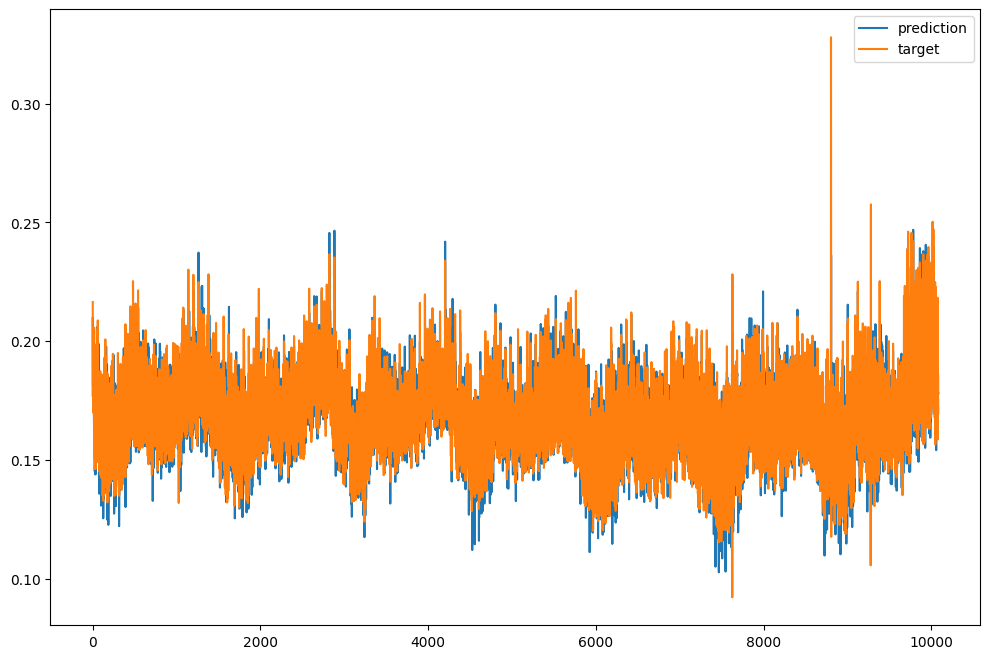

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.17704374, 0.21003482, 0.1892202 , ..., 0.18619925, 0.17765468,
       0.1781044 ])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 3.9207063615322113 %
RMSE 0.008958936668932438
MAPE 3.9261579513549805 %


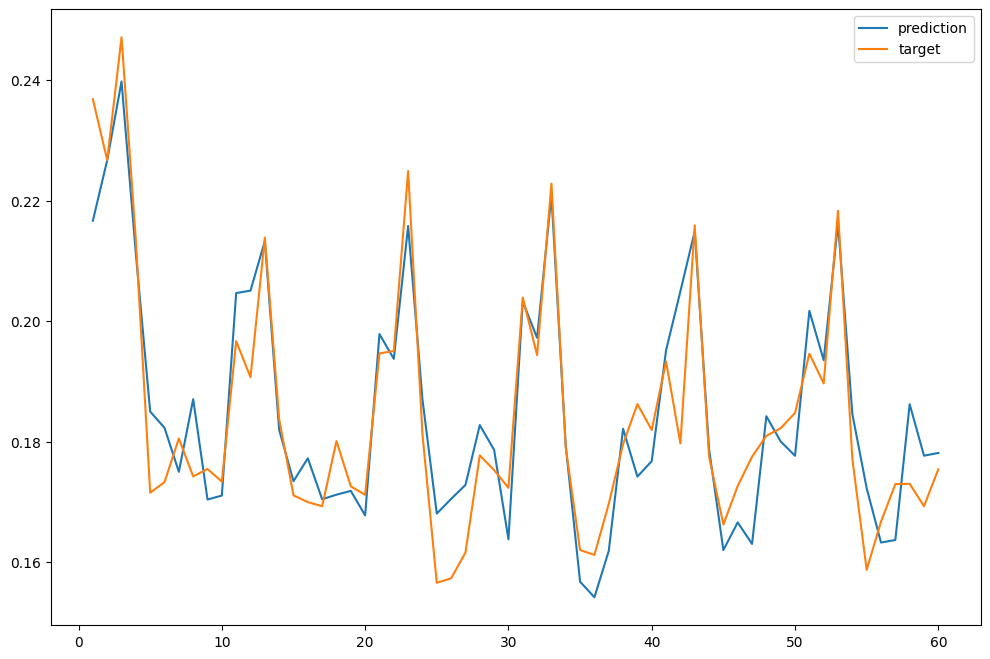

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.41721409114580305